## DSGE Unemployment

### 1.Data pre-process

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

unemployment_df = pd.read_excel("US_unemployment_annual.xlsx", skiprows=10)
fedfunds_df = pd.read_excel("FEDFUNDS.xlsx")
gdp_df = pd.read_excel("GDPC1.xlsx")


c:\ProgramData\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
# data cleaning unemployment
unemployment_df = unemployment_df.rename(columns={unemployment_df.columns[0]: "Year", unemployment_df.columns[1]: "UnemploymentRate"})
unemployment_df = unemployment_df[pd.to_numeric(unemployment_df["Year"], errors="coerce").notnull()]
unemployment_df["Year"] = unemployment_df["Year"].astype(int)
unemployment_df = unemployment_df[(unemployment_df["Year"] >= 2010) & (unemployment_df["Year"] <= 2024)]
unemployment_df["UnemploymentRate"] = pd.to_numeric(unemployment_df["UnemploymentRate"], errors='coerce')
unemployment_df.reset_index(drop=True, inplace=True)

# data cleaning fedfunds
fedfunds_df['observation_date'] = pd.to_datetime(fedfunds_df['observation_date'])
fedfunds_df['Year'] = fedfunds_df['observation_date'].dt.year
fedfunds_annual = fedfunds_df.groupby('Year')['FEDFUNDS'].mean().reset_index()

# data cleaning GDP
gdp_df['observation_date'] = pd.to_datetime(gdp_df['observation_date'])
gdp_df['Year'] = gdp_df['observation_date'].dt.year
gdp_annual = gdp_df.groupby('Year')['GDPC1'].mean().reset_index()

# merge
merged_df = pd.merge(unemployment_df[['Year', 'UnemploymentRate']], fedfunds_annual, on='Year', how='left')
merged_df = pd.merge(merged_df, gdp_annual, on='Year', how='left')

merged_df.sort_values("Year", inplace=True)
merged_df["FEDFUNDS"] = merged_df["FEDFUNDS"].interpolate()
merged_df["GDPC1"] = merged_df["GDPC1"].interpolate()

In [ ]:
df_full = merged_df.dropna(subset=["UnemploymentRate", "FEDFUNDS", "GDPC1"]).copy()
df_full["u_lag"] = df_full["UnemploymentRate"].shift(1)
df_full["i_lag"] = df_full["FEDFUNDS"].shift(1)
df_full["y_lag"] = df_full["GDPC1"].shift(1)
df_full = df_full.dropna().reset_index(drop=True)

$$ u_t = \alpha + \beta_1 u_{t-1} + \beta_2 i_{t-1} + \beta_3 y_{t-1} + \varepsilon_t $$

Where：
- $ u_t $：Unemployment Rate 
- $i_{t-1}$ ：Lagged FEDFUNDS） 
- $y_{t-1}$：Lagged GDP
- $\varepsilon_t$ ：Error

In [ ]:
train_df = df_full[df_full["Year"] <= 2020].copy()
X_train = train_df[["u_lag", "i_lag", "y_lag"]]
y_train = train_df["UnemploymentRate"]

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
initial_row = df_full[df_full["Year"] == 2020].iloc[0]
predicted = []
last_u = initial_row["UnemploymentRate"]

for year in range(2021, 2025):
    i_lag = merged_df.loc[merged_df["Year"] == year - 1, "FEDFUNDS"].values[0]
    y_lag = merged_df.loc[merged_df["Year"] == year - 1, "GDPC1"].values[0]
    
    x_pred = np.array([[last_u, i_lag, y_lag]])
    u_pred = model.predict(x_pred)[0]
    
    predicted.append({
        "Year": year,
        "Predicted_UnemploymentRate": u_pred
    })
    
    last_u = u_pred  


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


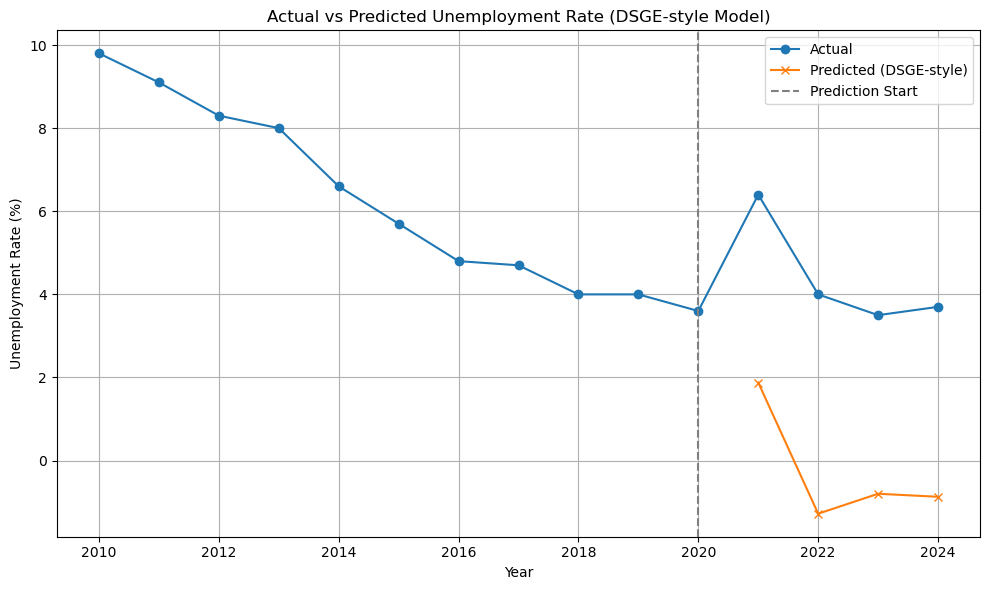

In [ ]:
predicted_df = pd.DataFrame(predicted)
full_df = pd.merge(merged_df, predicted_df, on="Year", how="left")


plt.figure(figsize=(10, 6))
plt.plot(full_df["Year"], full_df["UnemploymentRate"], label="Actual", marker='o')
plt.plot(full_df["Year"], full_df["Predicted_UnemploymentRate"], label="Predicted (DSGE-style)", marker='x')
plt.axvline(2020, color='gray', linestyle='--', label="Prediction Start")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.title("Actual vs Predicted Unemployment Rate (DSGE-style Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Introducing pandemic:
$$ u_t = \alpha + \beta_1 u_{t-1} + \beta_2 i_{t-1} + \beta_3 y_{t-1} + \gamma D_t + \varepsilon_t $$

Where：
- $D_t = 1$  if year == 2020 or 2021 or 2022, else 0  
- $\gamma$ ：Shock  

c:\ProgramData\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklear

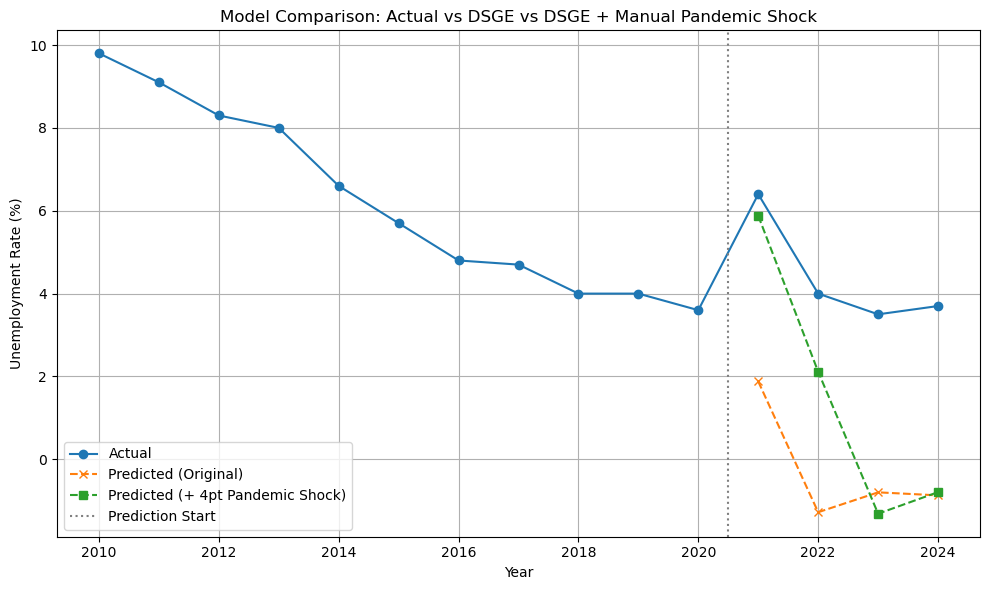

In [ ]:
# Re-import necessary files
fedfunds_df = pd.read_excel("FEDFUNDS.xlsx")
gdp_df = pd.read_excel("GDPC1.xlsx")

# Clean and merge FEDFUNDS
fedfunds_df['observation_date'] = pd.to_datetime(fedfunds_df['observation_date'])
fedfunds_df['Year'] = fedfunds_df['observation_date'].dt.year
fedfunds_annual = fedfunds_df.groupby('Year')['FEDFUNDS'].mean().reset_index()

# Clean and merge GDP
gdp_df['observation_date'] = pd.to_datetime(gdp_df['observation_date'])
gdp_df['Year'] = gdp_df['observation_date'].dt.year
gdp_annual = gdp_df.groupby('Year')['GDPC1'].mean().reset_index()

# Reload and clean unemployment data
unemployment_df = pd.read_excel("US_unemployment_annual.xlsx", skiprows=10)
unemployment_df = unemployment_df.rename(columns={unemployment_df.columns[0]: "Year", unemployment_df.columns[1]: "UnemploymentRate"})
unemployment_df = unemployment_df[pd.to_numeric(unemployment_df["Year"], errors="coerce").notnull()]
unemployment_df["Year"] = unemployment_df["Year"].astype(int)
unemployment_df = unemployment_df[(unemployment_df["Year"] >= 2010) & (unemployment_df["Year"] <= 2024)]
unemployment_df["UnemploymentRate"] = pd.to_numeric(unemployment_df["UnemploymentRate"], errors='coerce')
unemployment_df.reset_index(drop=True, inplace=True)

# Merge all
merged_df = pd.merge(unemployment_df[['Year', 'UnemploymentRate']], fedfunds_annual, on='Year', how='left')
merged_df = pd.merge(merged_df, gdp_annual, on='Year', how='left')
merged_df.sort_values("Year", inplace=True)
merged_df["FEDFUNDS"] = merged_df["FEDFUNDS"].interpolate()
merged_df["GDPC1"] = merged_df["GDPC1"].interpolate()

# Define pandemic dummy (2020-2022)
merged_df["PandemicDummy"] = merged_df["Year"].apply(lambda x: 1 if x in [2020, 2021, 2022] else 0)

# Build model: add adjustable dummy weight manually
manual_dummy_weight = 4 # simulate stronger effect of radical uncertainty

# Prepare lags
df = merged_df.dropna(subset=["UnemploymentRate", "FEDFUNDS", "GDPC1"]).copy()
df["u_lag"] = df["UnemploymentRate"].shift(1)
df["i_lag"] = df["FEDFUNDS"].shift(1)
df["y_lag"] = df["GDPC1"].shift(1)
df = df.dropna().reset_index(drop=True)

# Fit model without dummy
train_df = df[df["Year"] <= 2020].copy()
X_train = train_df[["u_lag", "i_lag", "y_lag"]]
y_train = train_df["UnemploymentRate"]
model_orig = LinearRegression().fit(X_train, y_train)

# Predict with manual pandemic shock added
last_u = train_df[train_df["Year"] == 2020]["UnemploymentRate"].values[0]
predicted_shock = []

for year in range(2021, 2025):
    i_lag = merged_df.loc[merged_df["Year"] == year - 1, "FEDFUNDS"].values[0]
    y_lag = merged_df.loc[merged_df["Year"] == year - 1, "GDPC1"].values[0]
    dummy = merged_df.loc[merged_df["Year"] == year, "PandemicDummy"].values[0]
    
    x_pred = np.array([[last_u, i_lag, y_lag]])
    base_pred = model_orig.predict(x_pred)[0]
    u_pred = base_pred + dummy * manual_dummy_weight  # apply stronger shock
    
    predicted_shock.append({
        "Year": year,
        "Predicted_Unemployment_With_Shock": u_pred
    })
    last_u = u_pred

predicted_df = pd.DataFrame(predicted_shock)
compare_df = pd.merge(merged_df, predicted_df, on="Year", how="left")

# Also compute original predictions for comparison
last_u = train_df[train_df["Year"] == 2020]["UnemploymentRate"].values[0]
predicted_orig = []

for year in range(2021, 2025):
    i_lag = merged_df.loc[merged_df["Year"] == year - 1, "FEDFUNDS"].values[0]
    y_lag = merged_df.loc[merged_df["Year"] == year - 1, "GDPC1"].values[0]
    x_pred = np.array([[last_u, i_lag, y_lag]])
    u_pred = model_orig.predict(x_pred)[0]
    predicted_orig.append({
        "Year": year,
        "Predicted_Unemployment_Original": u_pred
    })
    last_u = u_pred

compare_df = pd.merge(compare_df, pd.DataFrame(predicted_orig), on="Year", how="left")

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(compare_df["Year"], compare_df["UnemploymentRate"], label="Actual", marker='o')
plt.plot(compare_df["Year"], compare_df["Predicted_Unemployment_Original"], label="Predicted (Original)", linestyle='--', marker='x')
plt.plot(compare_df["Year"], compare_df["Predicted_Unemployment_With_Shock"], label=f"Predicted (+ {manual_dummy_weight}pt Pandemic Shock)", linestyle='--', marker='s')
plt.axvline(2020, color='gray', linestyle=':', label="Prediction Start")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.title("Model Comparison: Actual vs DSGE vs DSGE + Manual Pandemic Shock")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




$$ u_t = \alpha + \beta_1 u_{t-1} + \beta_2 i_{t-1} + \beta_3 y_{t-1} + \gamma_1 D_t^{\text{pandemic}} + \gamma_2 D_t^{\text{LLM}} + \varepsilon_t $$

Where：

- $gamma_1$ ： +4 pandemic shock  
- $gamma_2$ ： +3.2 LLM shock

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not ha

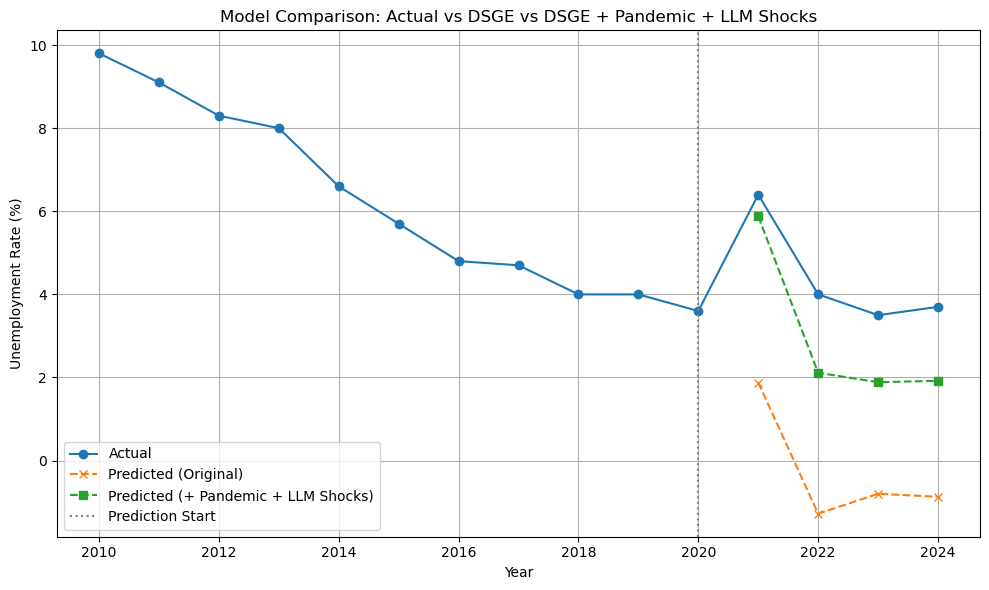

In [55]:
# Define manual shock values
pandemic_shock_weight = 4.0
llm_shock_weight = 3.2

# Add LLM dummy for 2023-2024
merged_df["LLMShockDummy"] = merged_df["Year"].apply(lambda x: 1 if x in [2023, 2024] else 0)

# Refit base model using data up to 2020
df = merged_df.dropna(subset=["UnemploymentRate", "FEDFUNDS", "GDPC1"]).copy()
df["u_lag"] = df["UnemploymentRate"].shift(1)
df["i_lag"] = df["FEDFUNDS"].shift(1)
df["y_lag"] = df["GDPC1"].shift(1)
df = df.dropna().reset_index(drop=True)

train_df = df[df["Year"] <= 2020].copy()
X_train = train_df[["u_lag", "i_lag", "y_lag"]]
y_train = train_df["UnemploymentRate"]
model = LinearRegression().fit(X_train, y_train)

# Predict 2021–2024 with both pandemic and LLM shocks
last_u = train_df[train_df["Year"] == 2020]["UnemploymentRate"].values[0]
predicted_shock = []

for year in range(2021, 2025):
    i_lag = merged_df.loc[merged_df["Year"] == year - 1, "FEDFUNDS"].values[0]
    y_lag = merged_df.loc[merged_df["Year"] == year - 1, "GDPC1"].values[0]
    pandemic_dummy = merged_df.loc[merged_df["Year"] == year, "PandemicDummy"].values[0]
    llm_dummy = merged_df.loc[merged_df["Year"] == year, "LLMShockDummy"].values[0]

    x_pred = np.array([[last_u, i_lag, y_lag]])
    base_pred = model.predict(x_pred)[0]
    u_pred = base_pred + pandemic_dummy * pandemic_shock_weight + llm_dummy * llm_shock_weight

    predicted_shock.append({
        "Year": year,
        "Predicted_Unemployment_With_Both_Shocks": u_pred
    })
    last_u = u_pred

# Prepare original model prediction (no shocks)
last_u = train_df[train_df["Year"] == 2020]["UnemploymentRate"].values[0]
predicted_orig = []

for year in range(2021, 2025):
    i_lag = merged_df.loc[merged_df["Year"] == year - 1, "FEDFUNDS"].values[0]
    y_lag = merged_df.loc[merged_df["Year"] == year - 1, "GDPC1"].values[0]
    x_pred = np.array([[last_u, i_lag, y_lag]])
    u_pred = model.predict(x_pred)[0]
    predicted_orig.append({
        "Year": year,
        "Predicted_Unemployment_Original": u_pred
    })
    last_u = u_pred

# Merge for plotting
compare_df = pd.merge(merged_df, pd.DataFrame(predicted_shock), on="Year", how="left")
compare_df = pd.merge(compare_df, pd.DataFrame(predicted_orig), on="Year", how="left")


# Plot again with consistent styling for clarity
plt.figure(figsize=(10, 6))

# Actual values
plt.plot(compare_df["Year"], compare_df["UnemploymentRate"], label="Actual", marker='o', color='tab:blue')

# Original DSGE prediction
plt.plot(compare_df["Year"], compare_df["Predicted_Unemployment_Original"],
         label="Predicted (Original)", linestyle='--', marker='x', color='tab:orange')

# Improved model with both shocks
plt.plot(compare_df["Year"], compare_df["Predicted_Unemployment_With_Both_Shocks"],
         label="Predicted (+ Pandemic + LLM Shocks)", linestyle='--', marker='s', color='tab:green')

# Vertical line indicating start of prediction period
plt.axvline(2020, color='gray', linestyle=':', label="Prediction Start")

# Labels and style
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.title("Model Comparison: Actual vs DSGE vs DSGE + Pandemic + LLM Shocks")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
